# Cognitive Science Final Project
**Performance analysis for image classification Convolutional Neural Network based on neural structure of Mice Visual Cortex** 

This project I will be connecting the topics discussed in class about the continued study of Artificial Neural Networks with real-world data derived from the specific, cell-to-cell mapping of axonal tracts between neurons within a mouses visual cortex to model a convolutional neural network after. I will compare the performance of this real-world image processing network against the baseline to assess the importance of modeling artificial neural networks after biological neural structures.

Initial imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
from torch.distributions import normal
import networkx as nx
import time

Download Mouse visual cortex networks from <https://neurodata.io/project/connectomes/>

***ONLY RUN THIS CELL ONCE***

In [2]:
!wget https://s3.amazonaws.com/connectome-graphs/mouse/mouse_visual.cortex_1.graphml
!wget https://s3.amazonaws.com/connectome-graphs/mouse/mouse_visual.cortex_2.graphml

--2022-04-24 14:24:03--  https://s3.amazonaws.com/connectome-graphs/mouse/mouse_visual.cortex_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.199.128
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9054 (8.8K) [binary/octet-stream]
Saving to: ‘mouse_visual.cortex_1.graphml’

mouse_visual.cortex 100%[===================>]   8.84K  --.-KB/s    in 0s      

2022-04-24 14:24:04 (114 MB/s) - ‘mouse_visual.cortex_1.graphml’ saved [9054/9054]

--2022-04-24 14:24:04--  https://s3.amazonaws.com/connectome-graphs/mouse/mouse_visual.cortex_2.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.199.128
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48429 (47K) [binary/octet-stream]
Saving to: ‘mouse_visual.cortex_2.graphml’

mouse_visual.cortex 100%[===================>]  47.29K  --.-KB/s 

Function for visualization of visual cortex network of nuerons

In [3]:
# network analysis
node_colors = {'NA': 'red', 'Postsynaptic inhibitory target':'blue','Postsynaptic excitatory target':'green'}
def assess_neuron_network(G):
	typetwo = nx.get_node_attributes(G, 'type2')
	node_types_list = dict([(typ,[]) for typ in list(set(typetwo.values()))])

	sources = [n for n in G.nodes() if G.in_degree(n) == 0]
	sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
	for n in G.nodes():
		node_types_list[typetwo[n]].append(n)

	print("Mouse Visual Cortex Neuron-Network")
	print("# neurons in first layer  (Presynaptic sources) :", len(sources))
	print("# neurons in second layer (Postsynaptic targets):", len(sinks))
	return node_types_list

Download the MNIST digits data

In [4]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

## Initiate different models for the different neural structures. 
Now that we've initialized all the functions and classes needed to perform image classification, lets 


1.   Create a standard baseline SoftMax and Convolutional Neural Network models and train on the data 
2.   Analyze the structure of our 2 mouse visual cortex neuron networks
3.   Create Convolutional Neural Networks based on the structure of the Mouse visual cortex network's
4.   Compare performances (accuracy & loss) across all models  



##Defining a Convolutional Neural Network

Heres the meat: the neural network (variable for our different structures)

In [7]:
class CNN(nn.Module):
    
    def __init__(self, out_1=16, out_2=32):
        """Contructor"""
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    def forward(self, x):
        """Prediction"""
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    def activations(self, x):
        """outputs activation"""
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [8]:
# Training the model
n_epochs = 10
N_test = len(validation_dataset)
COST = 0

def train_model(model, n_epochs):
    start = time.time()
    cost_list, accuracy_list, learning_rate = [], [], 0.1
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)
    
    for epoch in range(n_epochs):
        COST, ep_time = 0, time.time()
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print('epoch %d, loss %.4f, train acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, COST, accuracy,
                 time.time() - ep_time))

    print('%.2f sec to train the CNN' % (time.time() - start))
    return model, cost_list, accuracy_list

##Baseline CNN Model
This is a basic structure for a Convolutional Neural Network to train on the images, if you were taking an intro to machine learing course, this structure would be given as a first-

In [9]:
# Create the baseline model
model_baseline = CNN(out_1=16, out_2=32)

We train the model for 10 epochs, **this cell may take a while to run** (3-5 minutes depending on connection)

In [10]:
model_baseline, cost_list_bl, accuracy_list_bl = train_model(model_baseline, n_epochs)

epoch 1, loss 275.6123, train acc 0.954, time 25.1 sec
epoch 2, loss 72.0106, train acc 0.972, time 21.5 sec
epoch 3, loss 53.5929, train acc 0.978, time 21.6 sec
epoch 4, loss 44.4194, train acc 0.980, time 22.2 sec
epoch 5, loss 38.4506, train acc 0.981, time 21.2 sec
epoch 6, loss 34.1116, train acc 0.982, time 21.6 sec
epoch 7, loss 30.7035, train acc 0.985, time 21.5 sec
epoch 8, loss 28.0849, train acc 0.985, time 21.2 sec
epoch 9, loss 25.9207, train acc 0.985, time 21.4 sec
epoch 10, loss 24.0578, train acc 0.986, time 21.7 sec
218.95 sec to train the CNN


Now that we have trained this model, we observe the accuracy and loss that we will compare our mouse visual cortex based neural networks to.

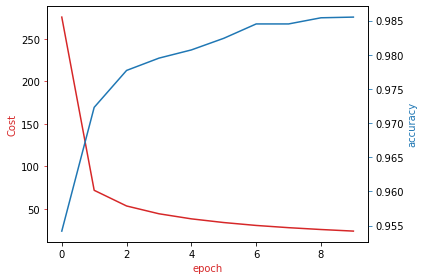

In [11]:
# Plot the loss and accuracy for baseline CNN
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list_bl, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list_bl, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Mouse visual cortex 1

**Data used:**
The data used in this project was sourced from <https://neurodata.io/project/connectomes/>.

The page "hosts animal connectomes produced using data from a multitude of labs, across model species, using different modalities. A 'connectome' is a specific, cell-to-cell mapping of axonal tracts between neurons, created from cellular data like electron microscopy." We download and use the Mouse connectome for this project.

Network Analysis for 

In [12]:
G_small = nx.read_graphml('mouse_visual.cortex_1.graphml')

In [13]:
node_types_list = assess_neuron_network(G_small)

Mouse Visual Cortex Neuron-Network
# neurons in first layer  (Presynaptic sources) : 9
# neurons in second layer (Postsynaptic targets): 18


Draw the graph to see how information flows from presynaptic to postsynaptic neurons via directed edges

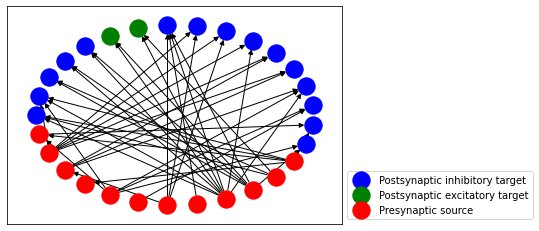

In [14]:
pos = nx.shell_layout(G_small)
for typ,nodes in node_types_list.items(): 
	label = typ if typ != 'NA' else 'Presynaptic source'
	nx.draw_networkx_nodes(G_small, pos = pos, nodelist = nodes, node_color = node_colors[typ], label = label)
nx.draw_networkx_edges(G_small, pos=pos)
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

Now that we know the structure of the mouse visual cortex, lets restructure the Neural Network to mirror the mouse's visual cortex  

In [15]:
# Create the CNN with structure based on the Mouse Visual Cortex
model1 = CNN(out_1=9, out_2=18)

Train the model and determine validation/test accuracy. **(This may take a long time)**

In [16]:
model1, cost_list_1, accuracy_list_1 = train_model(model1, n_epochs)

epoch 1, loss 335.8729, train acc 0.941, time 18.9 sec
epoch 2, loss 78.6690, train acc 0.963, time 18.4 sec
epoch 3, loss 58.5077, train acc 0.968, time 18.7 sec
epoch 4, loss 49.3996, train acc 0.971, time 18.5 sec
epoch 5, loss 43.6717, train acc 0.973, time 18.5 sec
epoch 6, loss 39.4670, train acc 0.976, time 18.6 sec
epoch 7, loss 36.1579, train acc 0.978, time 18.7 sec
epoch 8, loss 33.4332, train acc 0.980, time 18.8 sec
epoch 9, loss 31.1639, train acc 0.980, time 18.4 sec
epoch 10, loss 29.1753, train acc 0.981, time 18.5 sec
185.94 sec to train the CNN


## Mouse visual cortex 2

Now we do similar analysis and Neural Network creation and training based on the second, larger network of a mouse visual cortex. 

In [17]:
G_big = nx.read_graphml('mouse_visual.cortex_2.graphml')

In [18]:
node_types_list = assess_neuron_network(G_big)

Mouse Visual Cortex Neuron-Network
# neurons in first layer  (Presynaptic sources) : 10
# neurons in second layer (Postsynaptic targets): 184


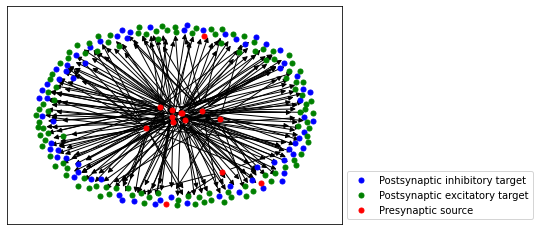

In [19]:
pos = nx.spring_layout(G_big)
for typ,nodes in node_types_list.items(): 
	label = typ if typ != 'NA' else 'Presynaptic source'
	nx.draw_networkx_nodes(G_big, pos = pos, node_size = 25, nodelist = nodes, node_color = node_colors[typ], label = label)
nx.draw_networkx_edges(G_big, pos=pos)
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

Now that we know the structure of this network, lets recreate it using our convolutional neural network.

In [20]:
# Create the CNN based on information flow of visual cortex 
model2 = CNN(out_1=10, out_2=182)

**This one takes the longest amount of time** (~10 mins)

In [21]:
model2, cost_list_2, accuracy_list_2 = train_model(model2, n_epochs)

epoch 1, loss 248.9709, train acc 0.960, time 53.4 sec
epoch 2, loss 63.2133, train acc 0.974, time 53.7 sec
epoch 3, loss 46.6760, train acc 0.978, time 52.8 sec
epoch 4, loss 38.1548, train acc 0.979, time 52.4 sec
epoch 5, loss 32.7043, train acc 0.981, time 52.3 sec
epoch 6, loss 28.7618, train acc 0.983, time 52.5 sec
epoch 7, loss 25.6832, train acc 0.984, time 52.2 sec
epoch 8, loss 23.1913, train acc 0.986, time 52.4 sec
epoch 9, loss 21.0693, train acc 0.986, time 53.4 sec
epoch 10, loss 19.1871, train acc 0.986, time 52.6 sec
527.62 sec to train the CNN


## Analyze results
**Compare Models**

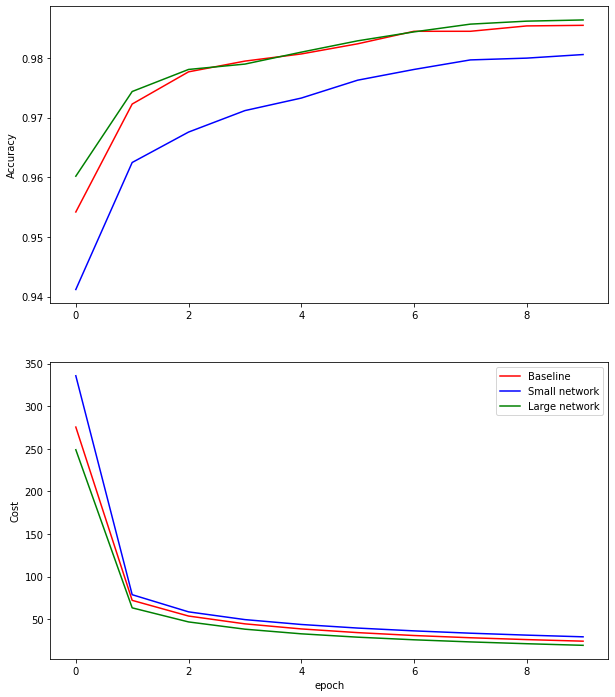

In [22]:
# Plot accuracy and loss for each NN
fig, ax = plt.subplots(2, 1, figsize=(10,12))
ax[0].plot(accuracy_list_bl, color='red', label = "Baseline")
ax[0].plot(accuracy_list_1, color='blue', label = "Small network")
ax[0].plot(accuracy_list_2, color='green', label = "Large network")
ax[0].set_ylabel('Accuracy')
    
ax[1].set_ylabel('Cost') 
ax[1].set_xlabel('epoch')
ax[1].plot(cost_list_bl, color='red', label = "Baseline")
ax[1].plot(cost_list_1, color='blue', label = "Small network")
ax[1].plot(cost_list_2, color='green', label = "Large network")
plt.legend()

We observe that while the smaller Visual Cortex network relatively underperforms, having a lower accuracy and higher error compared to the baseline model, the larger model of the Mouse Visual Cortex does the same or better than the baseline model, having a higher overall accuracy and lower validation error while training compared to the other models.  





##Conclusion

As we've seen, the connections of a Mouse's visual cortex, when translated to a Convolutional Nueral Network, are suffient for a basic computer vision task of digit classification, performing within a small margin of error against a baseline model for the task. 

This tells us about the importance of the structure of an artificial neural network, and how beneficial it is to be able to construct aritificial models based on real life neural networks. The more and more complex relationships we can simulate between nodes in a network takes us closer and closer to stronger and more reliable artificial intelligence, as well as a better understanding of intelligence and cognition as a whole.



##References

- animal neuron networks <https://neurodata.io/project/connectomes/>
- <https://www.tutorialspoint.com/pytorch/pytorch_convolutional_neural_network.htm>, for reference in creating Convolutional Neural Networks
- MNIST digits data